# Test SeT-3 model

Author: Jason Jiang (Xunfun Lee)

Data: 2024.01.16

### Load model

In [1]:
import os
import numpy as np
from PythonScripts.utility import LoadModel, SetDevice
import matplotlib.pyplot as plt

FILE_PATH = os.path.join("Data", "GM_Example", "El-Centro-50Hz-3000.txt")
MODEL_NAME = "SeT_1_HS_768_Layer_12_Head_12_Epoch_20_Acc_0.75_F1_10.0_Model.pth"

device = SetDevice()
model = LoadModel(MODEL_NAME).to(device)

GPU: cuda
CUDA device numbers:  1


### El-centro ground motion

In [2]:
import torch

el_centro = []

# 打开文件并读取数据
with open(FILE_PATH, 'r', encoding='utf-8') as file:
    next(file)  # 跳过表头

    for line in file:
        # 如果数据用空格分隔
        # columns = line.split()

        # 如果数据用制表符分隔
        columns = line.split('\t')

        if len(columns) > 1:
            try:
                el_centro.append(float(columns[1].strip()))
            except ValueError:
                # 处理无法转换为浮点数的情况
                print(f"无法转换的行：{line}")

el_centro = np.array(el_centro).reshape(-1, 1)
el_centro.shape

# 创建一个形状为 (1, 1) 的数组，其元素为 0
zero_array = np.array([[0]])

# 将这个 0 数组追加到原数组的末尾
el_centro = np.append(el_centro, zero_array, axis=0)
el_centro.shape

(3000, 1)

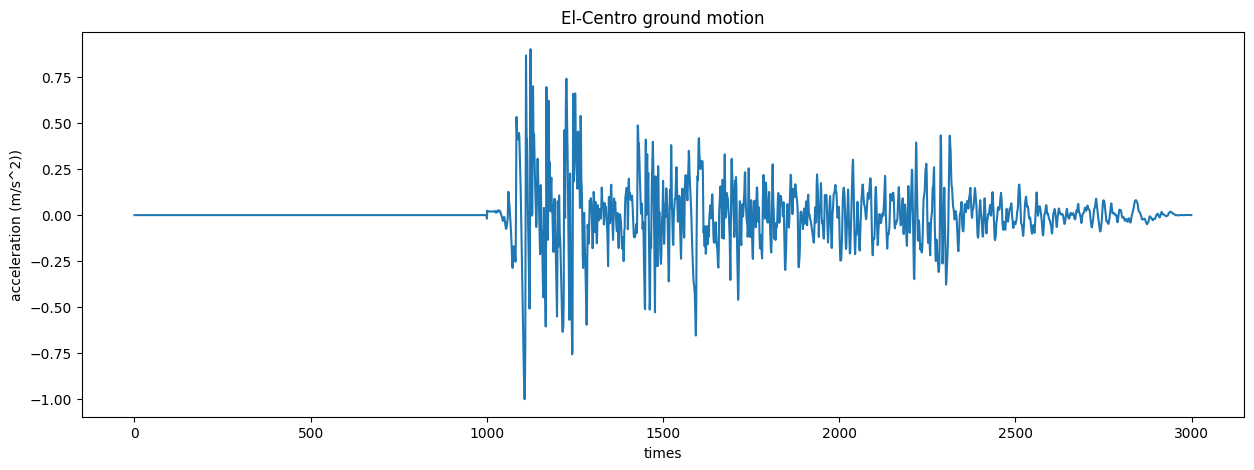

In [3]:
# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(el_centro)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('El-Centro ground motion')
plt.show()

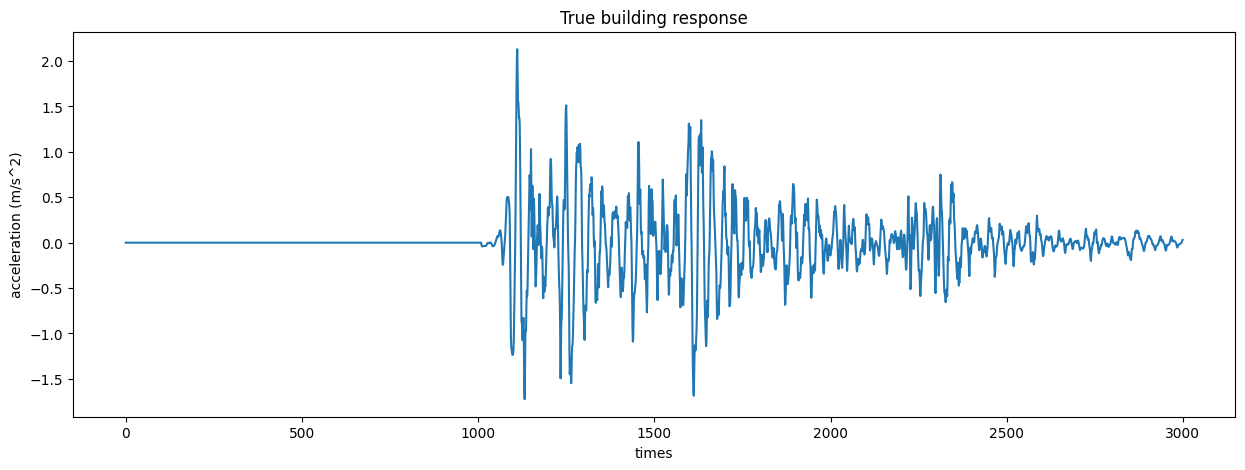

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

def extract_second_column(file_path):
    """
    Extracts the second column from a given text file.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # 提取第二列数据，转换为浮点数
    second_column = [float(line.split()[1]) for line in lines[1:]]

    return second_column

file_path = os.path.join("Data", "GM_Example", "Blg1_El-Centro-50Hz-3000_RoofAcc.txt")
el_centro_blg = extract_second_column(file_path)

# 将列表转换为numpy数组
el_centro_blg = np.array(el_centro_blg).reshape(-1, 1)

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(el_centro_blg)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2)')
plt.title('True building response')
plt.show()


### Pass through the model without decoder input

In [5]:
import torch

el_centro = torch.tensor(el_centro, dtype=torch.float32).to(device)  # 将数据转换为张量
el_centro = el_centro.unsqueeze(0)  # 将数据转换为张量

model.eval()  # 将模型设置为评估模式

with torch.no_grad():  # 在推理过程中，我们不需要计算梯度
    
    # 注意，由于我们只进行推理，decoder_input参数设置为None
    damage_state, dynamic_response = model(encoder_input=el_centro, decoder_input=None)

    # 输出结果
    damage_state, dynamic_response, damage_state.shape, dynamic_response.shape

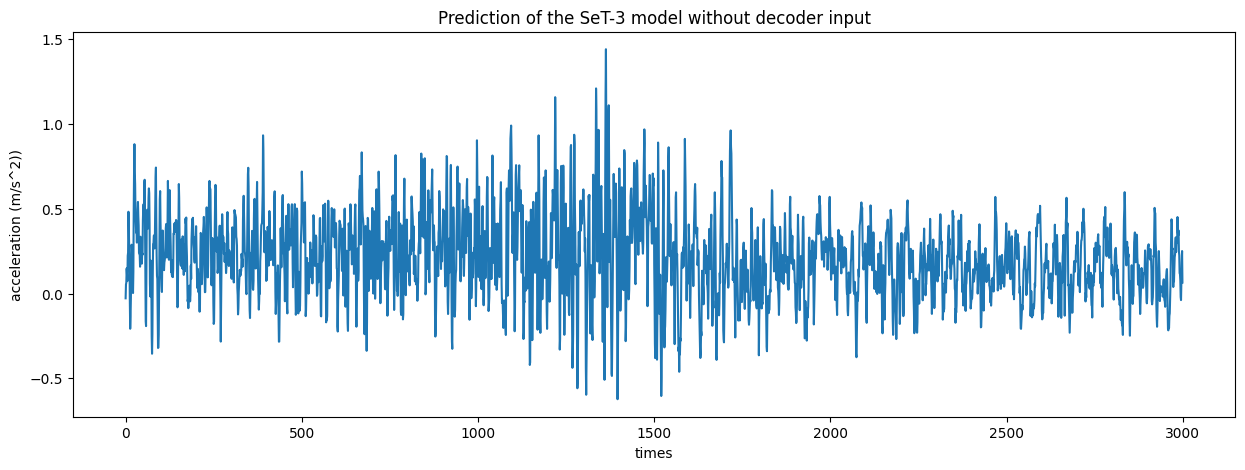

In [6]:
import matplotlib.pyplot as plt

# 将tensor转换为numpy数组，并移除多余的维度
numpy_array = dynamic_response.squeeze().cpu().detach().numpy()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(numpy_array)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('Prediction of the SeT-3 model without decoder input')
plt.show()

### Pass through the model with decoder input

In [7]:
model.eval()  # 将模型设置为评估模式

el_centro_blg = torch.tensor(el_centro_blg, dtype=torch.float32).unsqueeze(0).to(device)  # 将数据转换为张量

with torch.no_grad():  # 在推理过程中，我们不需要计算梯度
    
    # 注意，由于我们只进行推理，decoder_input参数设置为None
    damage_state, dynamic_response = model(encoder_input=el_centro, decoder_input=el_centro_blg)

    # 输出结果
    damage_state, dynamic_response, damage_state.shape, dynamic_response.shape

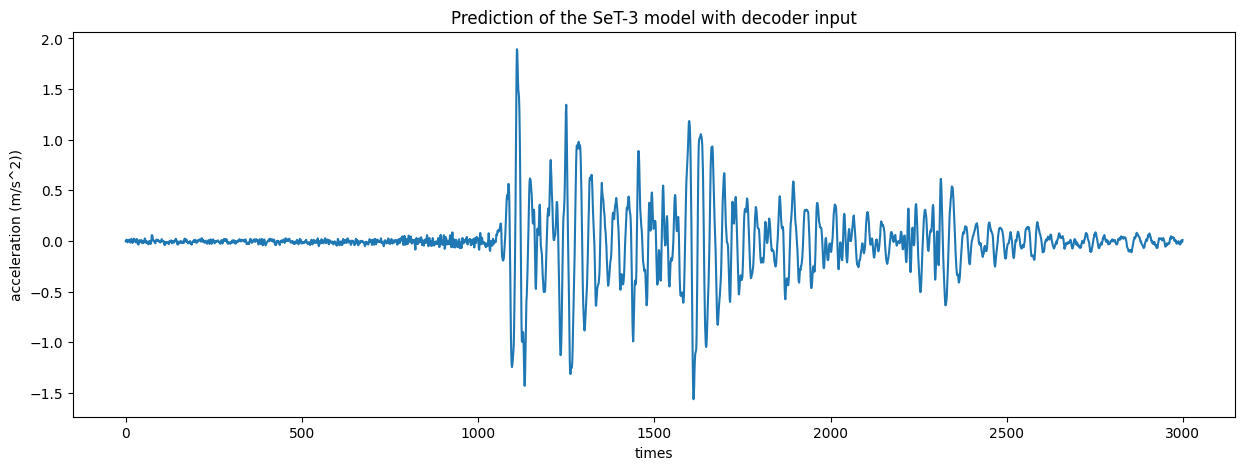

In [8]:
# 将tensor转换为numpy数组，并移除多余的维度
numpy_array = dynamic_response.squeeze().cpu().detach().numpy()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(numpy_array)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('Prediction of the SeT-3 model with decoder input')
plt.show()

## Using training data to test

### Load the data

In [9]:
import h5py

def ReadH5File(path:str,
               dataset_name:str) -> np.ndarray:
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file at {path} does not exist.")

    with h5py.File(path, 'r') as f:
        # Check if the dataset exists
        if dataset_name not in f:
            raise KeyError(f"Dataset {dataset_name} not found in the file.")

        data_read = f[dataset_name][:]

        # Check if the dataset is empty
        if data_read.size == 0:
            raise ValueError(f"The dataset {dataset_name} is empty.")

        print("Data read successfully")

    return data_read

In [12]:
Acc_GM_Train_Path = "Acc_GMs_train.h5"
dataset_name_acc_gm = 'Acc_GMs'
file_path = 'I:\Graduation\Data_MDOF\Data_h5'
Acc_GM_Train = ReadH5File(path=os.path.join(file_path, Acc_GM_Train_Path), dataset_name=dataset_name_acc_gm)

Acc_GM_Train.shape

Data read successfully


(100662, 3000)

In [13]:
Acc_Blg_Train_Path = "Acc_Blg_train.h5"
dataset_name_acc_blg = 'dataset_name'       # forget to set the name of dataset :(
Acc_Blg_Train = ReadH5File(path=os.path.join(file_path, Acc_Blg_Train_Path), dataset_name=dataset_name_acc_blg)

Acc_Blg_Train.shape

Data read successfully


(57, 1766, 3000)

In [14]:
Acc_Blg_Train_tp = Acc_Blg_Train.transpose(1, 0, 2)
Acc_Blg_Train_merge = Acc_Blg_Train_tp.reshape(100662,3000)

Acc_Blg_Train_merge.shape

(100662, 3000)

### Visulization

In [15]:
import matplotlib.pyplot as plt

def PlotA(times:np.ndarray, acc:np.ndarray, index:int, save:bool=False):
    plt.figure(figsize=(10, 2.5))
    plt.plot(times, acc[index], marker='o', linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

def PlotB(times:np.ndarray, acc:np.ndarray, index_blg:int, index_gm:int, save:bool=False):
    plt.figure(figsize=(10, 2.5))
    plt.plot(times, acc[index_blg][index_gm], marker='o', linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

indices of data: 52


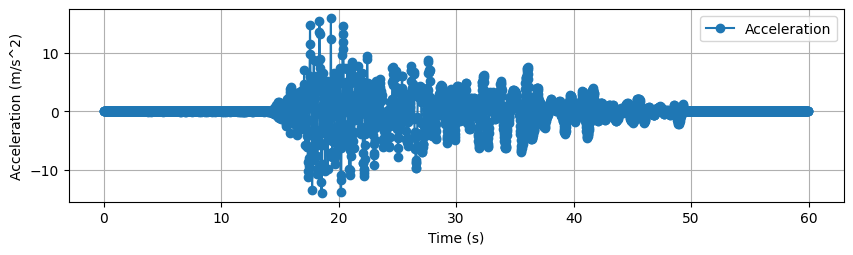

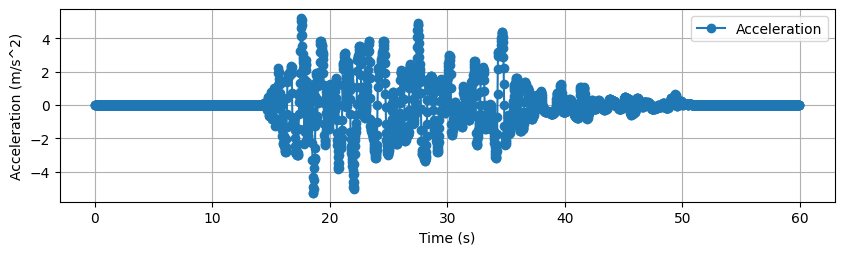

In [18]:
import random
index_data = random.randint(0, len(Acc_Blg_Train))
index_gm = index_data // 57
index_blg = index_data % 57

times = np.linspace(0, 59.98, 3000)
print(f"indices of data: {index_data}")

# train data
PlotA(times=times, acc=Acc_GM_Train, index=index_data, save=False)                          # original grounmotion data
PlotA(times=times, acc=Acc_Blg_Train_merge, index=index_data, save=False)                   # Check if the data after transformed is correct (blg)
# PlotB(times=times, acc=Acc_Blg_Train, index_gm=index_gm, index_blg=index_blg,save=False)    # the original data before transformed (blg)


### Pass through model

In [24]:
train_data = torch.tensor(Acc_GM_Train[index_data], dtype=torch.float32).to(device)  # 将数据转换为张量

train_data = train_data.unsqueeze(0).unsqueeze(-1)  # 将数据转换为张量

train_data.shape

torch.Size([1, 3000, 1])

In [26]:
model.eval()  # 将模型设置为评估模式

with torch.no_grad():  # 在推理过程中，我们不需要计算梯度
    
    # 注意，由于我们只进行推理，decoder_input参数设置为None
    damage_state, dynamic_response = model(encoder_input=train_data, decoder_input=None)

    # 输出结果
    damage_state, dynamic_response, damage_state.shape, dynamic_response.shape

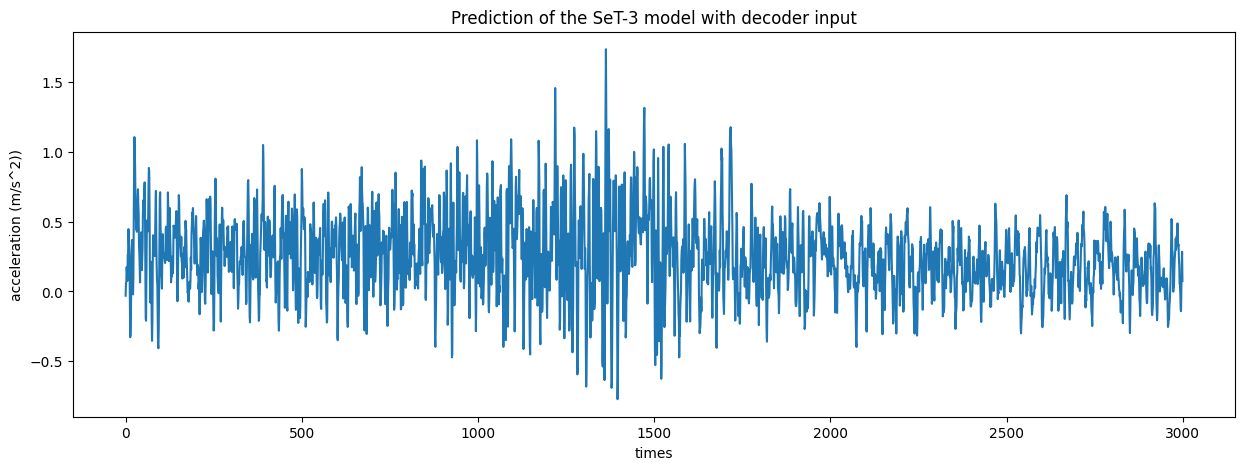

In [27]:
# 将tensor转换为numpy数组，并移除多余的维度
numpy_array = dynamic_response.squeeze().cpu().detach().numpy()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(numpy_array)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('Prediction of the SeT-3 model with decoder input')
plt.show()

### Pass through Zero tensor

In [38]:
zero_tensor = torch.zeros(1, 3000, 1).to(device)
ones_tensor = torch.ones(1, 3000, 1).to(device)

In [39]:
model.eval()  # 将模型设置为评估模式

with torch.no_grad():  # 在推理过程中，我们不需要计算梯度
    
    # 注意，由于我们只进行推理，decoder_input参数设置为None
    _, dynamic_response_zero = model(encoder_input=zero_tensor, decoder_input=None)
    _, dynamic_response_one = model(encoder_input=ones_tensor, decoder_input=None)


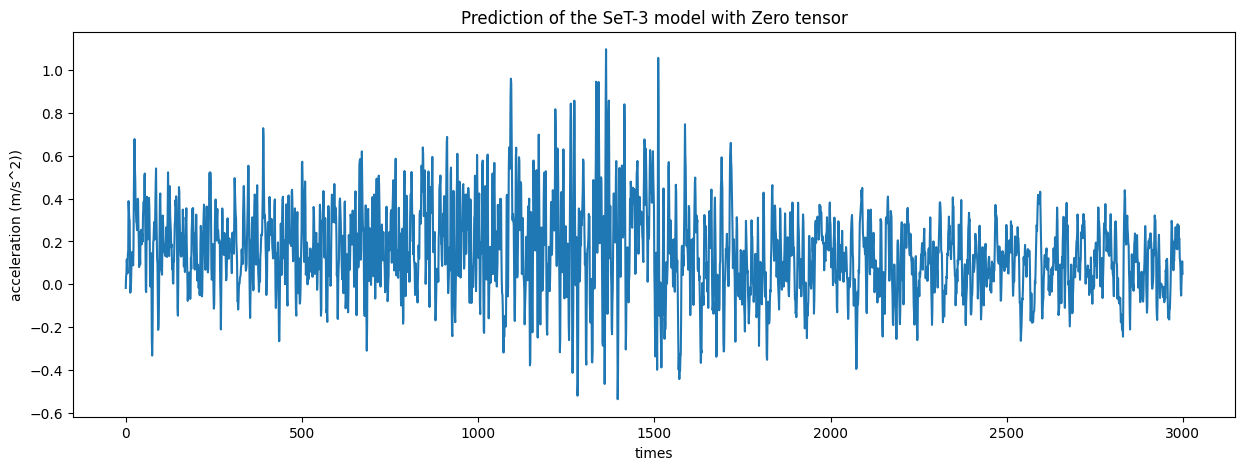

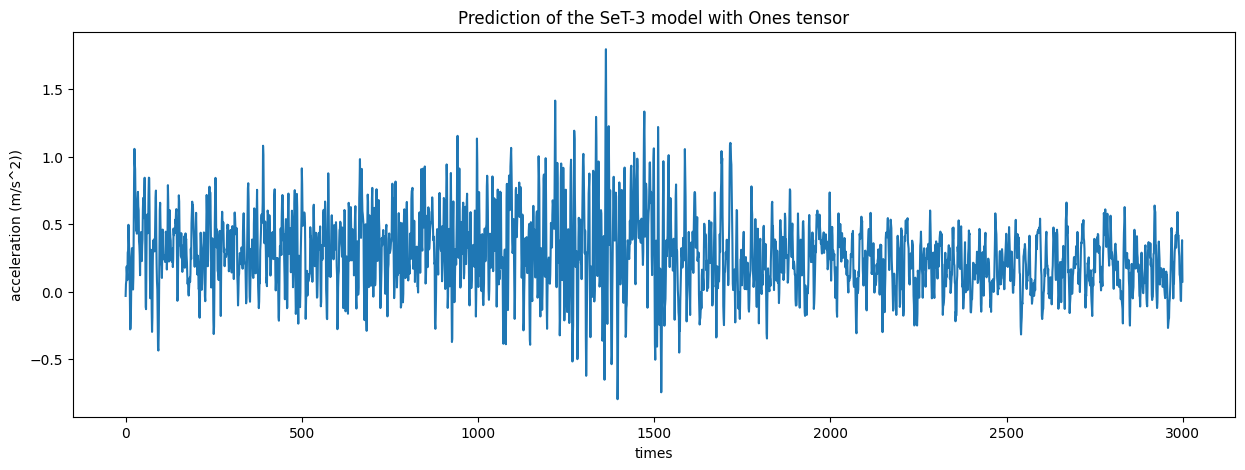

In [40]:
# 将tensor转换为numpy数组，并移除多余的维度
dynamic_response_zero = dynamic_response_zero.squeeze().cpu().detach().numpy()
dynamic_response_one = dynamic_response_one.squeeze().cpu().detach().numpy()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(dynamic_response_zero)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('Prediction of the SeT-3 model with Zero tensor')
plt.show()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(dynamic_response_one)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('Prediction of the SeT-3 model with Ones tensor')
plt.show()